In [44]:
from scipy.stats import truncnorm 
import matplotlib.pyplot as plt   #libreries
import numpy as np
from time import perf_counter  #start counting compilation time  ------------------
# first part 
#Defining fixed parameters 
start = perf_counter() #start counting here ----------------------

theta = np.pi 
g_1 = 2 
g_c = ((np.tan(theta)**2)*g_1**2)/16
w, y = -1, 1 
m_tau = 1.777 #en GeV/c^2
## m_l will be defined below 
m_mu= 105.66 * 10**-3 #muon mass on GeV/c^2 
c= (4*np.pi)**2 #this factor is for the denominator of a_mu 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--g_c**2--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Weinberg angle Sw=theta_w
alpha = 1/137.036
sw = np.sqrt(0.23116)
e = np.sqrt(4*np.pi*alpha) 
g_1 = e/np.sin(sw)
g_csqr = ((np.tan(sw)**2)*(g_1**2))/16 

#%%%%%%%%%%%%%%%%%%%--for defining v--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
m_z = 91.2 #GeV
v = (np.sin(2*sw)*m_z)/(2*np.sqrt(alpha*np.pi))
##########################--------------S_bmul y P_bmul----------#################################

########################----- let's define the values separately
#####################-----we need to know phi value
###################------we need this values also A_y, X_m y x_t
#################------ Similarly for A_y, we need the following parameters
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
####################### For this case we use UNIFORM distribution ######################################## 
import dist_trunc as dtr 
mu_SUSY, A_0 = dtr.dist_uniform(-15000,15000,1600000), dtr.dist_uniform(50,5000,1600000)
m_s, M1divms = dtr.dist_uniform(50,5000,1600000), dtr.dist_uniform(0.2,5,1600000)
beta = dtr.trunc_norm_sample(np.arctan(1),np.arctan(60),1600000) #change the number of n samples implies you must change to the same values of mu1sqr1,etc


#################################################################################################
def a_mutot(mu_SUSY,A_0,m_s,M1divms,beta):
    # A_y
    def A_y(A_0,beta):
        A_y = (1/np.sqrt(2))*y*A_0*v*np.cos(beta)
        return A_y
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_m--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def X_m(A_0,beta,mu_SUSY):
        X_m = (1/np.sqrt(2))*w*A_0*v*np.cos(beta) - mu_SUSY*m_mu*np.tan(beta)
        return X_m
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_t--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We still have X_t left to do 
    def X_t(A_0,beta,mu_SUSY):
        X_t = (1/np.sqrt(2))*A_0*v*np.cos(beta)-mu_SUSY*m_tau*np.tan(beta)
        return X_t

    phi= np.arctan(2*A_y(A_0,beta)/(X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY)))
    #for mu_1, mu_2, tau_1, tau_2 en el S_bmul
    mu_1s = 3*np.cos(phi/2)
    mu_2s = np.cos(phi/2)
    tau_1s = -np.sin(phi/2)
    tau_2s = -3*np.sin(phi/2)

    S_bmul1=np.array([mu_1s])
    S_buml2=np.array([mu_2s])
    S_buml3=np.array([tau_1s])
    S_buml4=np.array([tau_2s])

    #for mu_1, mu_2, tau_1, tau_2 en el P_bmul
    mu_1p = np.cos(phi/2)
    mu_2p=3*np.cos(phi/2)
    tau_1p = -3*np.sin(phi/2)
    tau_2p = -np.sin(phi/2)


    P_bmul1=np.array([mu_1p])
    P_bmul2=np.array([mu_2p])
    P_bmul3=np.array([tau_1p])
    P_bmul4=np.array([tau_2p])
    #print(P_bmul1.shape)  ###-array (1,N)--###
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--Slpeton masses (m_l)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We choose a value because m_l= m_mui o m_taui ; i=1,,2 for instance mu_mu1**2, 
    # so with table 2 and defined values

    R=np.sqrt(4*(A_y(A_0,beta)**2)+(X_t(A_0,beta,mu_SUSY)-X_m(A_0,beta,mu_SUSY))**2)
    def m_mu1sqr1(m_s): #process used for the next 3 functions of m_l
        m_sadj1 = m_s.copy()
        negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        k=0
        while negative_mask1.any(): #Use any for the True outcomes 'cause if you use .all() it means all must be True, with just one False
            m_srandtn1= dtr.dist_uniform(50,5000,1600000) #loop won't execute, try lots of sampling here so you won't need too much loops
            rand_val = np.random.choice(m_srandtn1, size=negative_mask1.sum(), replace=False)
            # negative_mask.sum() ensures you'll have same shape values of rand_val as mask and doesn't repeat values with replace False
            m_sadj1[negative_mask1] = rand_val # updates values where mask is TRUE, both in the same shape
            negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2 # They coincide with the positions of m_srandtn.                                                        #la posición de ms_randtn
            # Reevaluate the mask with the new values to confirm it’s resolved; if not, repeat the loop
            k = k + 1
        if k > 0:
            print("\nNumber of times the loop ran to change the value:", k)
        else:
            print("\nNo value change occurred, so the loop didn’t need to run")
        # print("\nUpdated m_s values:", m_sadj1)
        # m_mu1sqr1noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        # print("\nm_mu1sqr2 Values not fixed:", m_mu1sqr1noadj)  
        m_mu1sqr1 = (1/2)*(2*m_sadj1**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        return m_mu1sqr1
    def m_mu1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. similarly for the others
        m_sadj = m_s.copy()
        negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        # print(negative_mask)
        # print("Number of True entries where m_s <= the inequality:", np.count_nonzero(negative_mask))
        # print("Number of False entries (positive values where the m_s equality holds):", negative_mask.size - np.count_nonzero(negative_mask))
        # i=0
        #max_iters = 200   # loop limit just if you want
        while negative_mask.any(): 
            m_srandtn= dtr.dist_uniform(50,5000,1600000)  
            rand_val2=np.random.choice(m_srandtn,size=negative_mask.sum(), replace=False)
            m_sadj[negative_mask] = rand_val2
            negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2                                                                 #la posición de ms_randtn
            # We re-evaluate the mask with the new values to confirm it’s resolved; if not, we repeat the loop
        #     i = i+1
        # if i > 0:
        #     print("\nNumber of times the loop ran to change the value:", i)
        # if negative_mask.any():
        #     print("\nWARNING: unresolved entries:")
        # print("\nUpdated m_s values:", m_sadj)
        m_mu1sqr2 = (1/2)*(2*m_sadj**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        m_mu1sqr2noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        # print("\nm_mu1sqr2 values not fixed:", m_mu1sqr2noadj)
        return m_mu1sqr2


    # For mu_tau1**2 y mu_tau2**2 ----------------------------------------------------------------
    def m_tau1sqr1(m_s):
        m_sadj3 = m_s.copy()
        negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2
        l=0
        while negative_mask3.any(): 
            m_srandtn3= dtr.dist_uniform(50,5000,1600000)  #dimension must match
            #m_sadj3[negative_mask3] = m_srandtn3[negative_mask3] 
            rand_val3 = np.random.choice(m_srandtn3, size=negative_mask3.sum(), replace=False)
            m_sadj3[negative_mask3] = rand_val3 
            negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2    
            l = l+1
        if l > 0:
            print("\nNumber of times the loop ran to change the value:", l)
        else:
            print("\nNo value change occurred, so running the loop wasn’t required")
        # # print("\nUpdated m_s values:", m_sadj)
        m_tau1sqr1nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        #print("\nValores de m_tau1sqr2 sin ajuste:", m_tau1sqr1nadj)
        m_tau1sqr1 = (1/2)*(2*m_sadj3**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        return m_tau1sqr1 

    def m_tau1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. 
        m_sadj2 = m_s.copy()
        negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2

        # j=0
        while negative_mask2.any(): 
            m_srandtn2= dtr.dist_uniform(50,5000,1600000) 
            rand_val2 = np.random.choice(m_srandtn2, size=negative_mask2.sum(), replace=False)
            m_sadj2[negative_mask2] = rand_val2 
            negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2                                                               #la posición de ms_randtn
        #     j = j+1
        # if j > 0:
        #     print("\nNumber of times the loop ran to change the value:", j)
        # else:
        #     print("\nNo value change occurred, so running the loop wasn’t required")
        # print("\nUpdated m_s values:", m_sadj)

        m_tau1sqr2nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        #print("\nm_tau1sqr2 values not fixed:", m_tau1sqr2nadj)
        m_tau1sqr2 = (1/2)*(2*m_sadj2**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        return m_tau1sqr2

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--bino mass (m_B=m_N1)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # E_ms=np.mean(m_s)
    # M1 = trunc_norm_sample(E_ms*0.2,E_ms*5,1600)
    M1 = np.array([m_s*0.2,m_s*5]) #For simplicity we shall use this way of M1
    def m_B(mu_SUSY,beta):
        m_B = M1 - (((m_z**2)*(sw**2)*(M1+mu_SUSY*np.sin(2*beta)))/(mu_SUSY**2 - M1**2))
        #print(m_B.shape)
        #print(m_mu1sqr1(m_s).shape)
        return m_B

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--F_1^N & F_2^N--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ##########___Define the x functions_____##################
    x1 = m_B(mu_SUSY,beta)**2/m_mu1sqr1(m_s) #for m_mu1 
    nmask = x1 <= 0
    print("x1 values that produce a negative result", sum(nmask))

    x2 = m_B(mu_SUSY,beta)**2/m_mu1sqr2(m_s) #for m_mu2
    nmask2 = x2 <= 0
    print("x2 values — with the adjusted m_s that still produce a negative result", sum(nmask2))
    x3 = m_B(mu_SUSY,beta)**2/m_tau1sqr1(m_s) #for m_tau1(correction not needed for negative values)
    nmask3 = x3 <= 0
    print("x3 values that produce negative result", sum(nmask3))

    x4 = m_B(mu_SUSY,beta)**2/m_tau1sqr2(m_s) #for m_tau2 
    nmask4 = x4 <= 0 
    print("x4 values with the adjsusted m_s that still produce a negative result",sum(nmask4))
    def F_1N(x):
        return (2/((1-x)**4))*(1 - 6*x + 3*x**2 + 2*x**3 - 6*x**2*np.log(x))
    def F_2N(x):
        return (3/((1-x)**3))*(1 - x**2 + 2*x*np.log(x))
    a_mu1= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_bmul1**2 + P_bmul1**2)*(m_mu/(6*m_mu1sqr1(m_s)))*F_1N(x1) - (S_bmul1**2 - P_bmul1**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr1(m_s)))*F_2N(x1))
    a_mu2= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml2**2 + P_bmul2**2)*(m_mu/(6*m_mu1sqr2(m_s)))*F_1N(x2) - (S_buml2**2 - P_bmul2**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr2(m_s)))*F_2N(x2))
    a_mu3= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml3**2 + P_bmul3**2)*(m_mu/(6*m_tau1sqr1(m_s)))*F_1N(x3) - (S_buml3**2 - P_bmul3**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr1(m_s)))*F_2N(x3))
    a_mu4= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml4**2 + P_bmul4**2)*(m_mu/(6*m_tau1sqr2(m_s)))*F_1N(x4) - (S_buml4**2 - P_bmul4**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr2(m_s)))*F_2N(x4))
    a_mutot = a_mu1 + a_mu2 + a_mu3 + a_mu4
    return a_mutot

result = a_mutot(mu_SUSY,A_0,m_s,M1divms,beta)
print("Total values of a_mu:\n", result)
print(result.shape)
# Here we apply the condition to keep values bounded to the range that yields a solution
# between 3.15 and 4.15 sigmas of a_muSUSY (i.e., within the [3.15, 4.15]σ band for a_muSUSY) because that's what we're looking for
a_muvalid = np.array([])
a_mususy = 200.445e-11 #allowed limit that can solve the anomaly
tol = 152.145e-11
a_muvalid = np.append(a_muvalid, result[(tol <= result) & (result <= a_mususy)])
# print("The values that satisfy the condition (i.e., yield a solution between 3.15 and 4.15 sigmas of a_muSUSY):\n", a_muvalid)
# First, a_mutot has shape (2, 100) while the masks are (N,) (1-D). Even if we flatten,
# mu_SUSY would be (100,) and a_mutot would become (200,), which don’t match.
# Therefore, we need to split a_mutot and compare row by row, so we end up with two (100,) arrays.

# Work with each row individually
result_row1 = result[0, :]
result_row2 = result[1, :]
# Make the masks for each row 
mask_row1 = (result_row1 >= tol) & (result_row1 <= a_mususy)
mask_row2 = (result_row2 >= tol) & (result_row2 <= a_mususy)

# Apply masks to mu_SUSY
filtered_mususy_row1 = mu_SUSY[mask_row1]
filtered_mususy_row2 = mu_SUSY[mask_row2]
#print(filtered_mususy_row1.shape, "filtered_mususy_row1")
# Concatenate the filtered results of both rows
combined_filtered_mususy = np.concatenate((filtered_mususy_row1, filtered_mususy_row2))

# Apply masks to the other arrays and concatenate
filtered_A0_row1 = A_0[mask_row1]
filtered_A0_row2 = A_0[mask_row2]
combined_filtered_A0 = np.concatenate((filtered_A0_row1, filtered_A0_row2))

filtered_ms_row1 = m_s[mask_row1]
filtered_ms_row2 = m_s[mask_row2]
combined_filtered_ms = np.concatenate((filtered_ms_row1, filtered_ms_row2))

filtered_m1divms_row1 = M1divms[mask_row1]
filtered_m1divms_row2 = M1divms[mask_row2]
combined_filtered_m1divms = np.concatenate((filtered_m1divms_row1, filtered_m1divms_row2))

filtered_beta_row1 = beta[mask_row1]
filtered_beta_row2 = beta[mask_row2]
combined_filtered_beta = np.concatenate((filtered_beta_row1, filtered_beta_row2))
# Print the combined filtered results to recover the full set of parameters,
# rather than a partition of them from a_mutot.
# print("\nFiltered values of mu_SUSY, A0, m_s, M1divms & beta that meet the condition:")
#print("Combined Filtered mu_SUSY:\n", combined_filtered_mususy)
#print("Combined Filtered A0:\n", combined_filtered_A0)
#print("Combined Filtered m_s:\n", combined_filtered_ms)
#print("Combined Filtered M1divms:\n", combined_filtered_m1divms)
#print("Combined Filtered beta:\n", combined_filtered_beta)
#Joining all parameters in one array but with subsets
filtered_parameters = list(zip(combined_filtered_mususy, combined_filtered_A0, combined_filtered_ms, combined_filtered_m1divms, combined_filtered_beta))
#print("\nfiltered values of mu_SUSY, A0, m_s, M1divms & beta that satisfy the condition but grouped into subsets of their union:" , "\n",filtered_parameters)
end = perf_counter()
print(f'Duración(s): {end-start}')
filtered_params_arr = np.array(filtered_parameters)
print(f'Valores filtrados: {filtered_params_arr.shape}')
print(f'forma del a_muvalid: {a_muvalid.shape}')
X = filtered_params_arr
y = a_muvalid  #this definitions are for the neural network 


No value change occurred, so the loop didn’t need to run
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

No value change occurred, so the loop didn’t need to run

No value change occurred, so the loop didn’t need to run

Number of times the loop ran to change the value: 2

Number of times the loop ran to change the value: 2
Total values of a_mu:
 [[ 1.11305511e-10  3.47466456e-11  3.95749498e-09 ...  8.96780006e-09
  -1.38562330e-09  2.71128965e-11]
 [ 1.49765248e-11  4.69007593e-12  4.88323586e-10 ...  1.28039851e-09
  -2.83108226e-09  3.65248788e-12]]
(2, 1600000)
Duración(s): 54.867139199981466
Valores filtrados: (42279, 5)
forma del a_muvalid: (42279,)


In [45]:
#some libraries
#the filter parameters will be our input for the NN 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,  make_scorer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [46]:
# Verify original data
print("Original output data (y):")
print(y)
#let's split into training and test data (X are filtered_params & y our a_muvalid)
# We need to scale the y values (a_muvalid) because they are on the order of 1e-9, which makes training the NN harder.
# Scale the y values
# Scale X and y using different scalers
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten() # reshape converts a 1D array into a 2D array, and .flatten converts a 2D matrix back to a 1D array as it originally was.


# Check scaled y values
print("\nOutput scaled (y) values:")
print(y_scaled)

# Same check for X
print("\nOutput scaled (X) values:")
print(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42) # random_state ensures the same data split every time the code runs; otherwise, you'd get a different split on each run.

Original output data (y):
[1.53432376e-09 1.54611370e-09 1.53120488e-09 ... 1.53644279e-09
 1.54752218e-09 1.57014764e-09]

Output scaled (y) values:
[0.02664943 0.05106076 0.02019172 ... 0.03103693 0.05397704 0.10082353]

Output scaled (X) values:
[[-1.27008772  1.36986737  0.69633662 -0.2726865   1.44203179]
 [ 0.58946246 -1.4361297  -0.67786708  0.89946337  1.60319418]
 [-0.07444994  1.04473973  0.39488084  0.29690306  1.66054833]
 ...
 [ 0.7776562   0.64303072 -0.75917311 -0.71189305  0.06640736]
 [ 0.48837292 -0.59410327 -1.19350146  1.2427382   0.37933185]
 [-0.31023296 -0.91282058 -1.43157129 -1.11890795  1.98947759]]


In [47]:
start = perf_counter() 
model = Sequential([
    Input(shape=(5,)), #create the input layer explicity with 5 features 
    Dense(128, activation='relu', input_shape=(5,)), # 128 neurons, and input_dim=5 because there are 5 features per sample — (first layer, together with the above).
    # Dropout(0.5),  # dropout helps prevent overfitting.
    Dense(128, activation='relu'), 
    Dropout(0.2),  
    #Dropout(0.2),
    Dense(128, activation='relu'), # Second layer
    Dropout(0.2), # Turn off  50% or 20% of units in each iteration during training 
    # Dense(64, activation='relu'), # capa oculta con 64 neuronas #Aquí estamos probando con cuantas capas se ajusta mejor 
    # Dropout(0.5), # Apaga el 50% de las neuronas en cada iteración durante el entrenamiento
    Dense(1, activation='linear') # Output layer with one unit
])


# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error') # We tested learning rates of 0.1, 1e-1, 1e-2, 1e-3, 1e-4, and 1e-5, and the most suitable was --> 1e-3 <--
from tensorflow.keras.callbacks import EarlyStopping 

early_stop= EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train el modelo
#model.fit(X_train, y_train, epochs=80, batch_size=10, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])# We tested batch sizes of 8, 16, 32, and 64; 32 worked best.
# We also tried between 10 and 90 epochs with this configuration.
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Predict with model
y_pred_scaled = model.predict(X_test)

# Inverse-transform (unscale) the predictions to return to the original ranges
y_pred = scaler_y.inverse_transform(y_pred_scaled)

#Unscale real values in order to compare both
y_test_descaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()  
print("Unscaled predictions:")
print(y_pred)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_descaled, y_pred)
mae = mean_absolute_error(y_test_descaled, y_pred)
r2 = r2_score(y_test_descaled, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

end= perf_counter()
print(f'Time(s): {end-start}')
# Imprimir las predicciones y los valores reales
print("\nPredictions vs Real values:")
for i in range(len(y_test_descaled)):
    print(f'Predicción: {y_pred[i][0]:.10f}, Valor Real: {y_test_descaled[i]:.10f}')
    

D:\Santi\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0966 - val_loss: 0.0438
Epoch 2/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0426 - val_loss: 0.0340
Epoch 3/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0340 - val_loss: 0.0299
Epoch 4/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0313 - val_loss: 0.0296
Epoch 5/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0301 - val_loss: 0.0263
Epoch 6/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0264 - val_loss: 0.0203
Epoch 7/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0204 - val_loss: 0.0139
Epoch 8/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 9/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0148 - val_loss: 0.0123
Epoch 10/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 11/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 12/50
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

In [48]:
import importlib, a_mu_susy_uniform 
a_mu_susy = importlib.reload(a_mu_susy_uniform) #this is for obtain new values on each call you do 
X = a_mu_susy_uniform.X
y= a_mu_susy_uniform.y
print(f'Filtered parameters shape and values:{X.shape}, {X}')
print(f'$a_muvalid$ related to this parameters shape and values:{y.shape}, {y}')


No value change occurred, so the loop didn’t need to run
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

No value change occurred, so the loop didn’t need to run

No value change occurred, so the loop didn’t need to run

Number of times the loop ran to change the value: 2

Number of times the loop ran to change the value: 2
Duración(s): 57.15226160013117

No value change occurred, so the loop didn’t need to run
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 2
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsuste

## Trying now with gamma distribution test

In [49]:
from scipy.stats import truncnorm 
import matplotlib.pyplot as plt   #libreries
import numpy as np
from time import perf_counter  #start counting compilation time  ------------------
# first part 
#Defining fixed parameters 
start = perf_counter() #start counting here ----------------------

theta = np.pi 
g_1 = 2 
g_c = ((np.tan(theta)**2)*g_1**2)/16
w, y = -1, 1 
m_tau = 1.777 #en GeV/c^2
## m_l will be defined below 
m_mu= 105.66 * 10**-3 #muon mass on GeV/c^2 
c= (4*np.pi)**2 #this factor is for the denominator of a_mu 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--g_c**2--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Weinberg angle Sw=theta_w
alpha = 1/137.036
sw = np.sqrt(0.23116)
e = np.sqrt(4*np.pi*alpha) 
g_1 = e/np.sin(sw)
g_csqr = ((np.tan(sw)**2)*(g_1**2))/16 

#%%%%%%%%%%%%%%%%%%%--for defining v--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
m_z = 91.2 #GeV
v = (np.sin(2*sw)*m_z)/(2*np.sqrt(alpha*np.pi))
##########################--------------S_bmul y P_bmul----------#################################

########################----- let's define the values separately
#####################-----we need to know phi value
###################------we need this values also A_y, X_m y x_t
#################------ Similarly for A_y, we need the following parameters
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
####################### For this case we use UNIFORM distribution ######################################## 
import dist_trunc as dtr 
mu_SUSY, A_0 = dtr.gamma_trunc(2,-15000,15000,1600000), dtr.gamma_trunc(2,50,5000,1600000)
m_s, M1divms = dtr.gamma_trunc(2,50,5000,1600000), dtr.gamma_trunc(2,0.2,5,1600000)
beta = dtr.gamma_trunc(2,np.arctan(1),np.arctan(60),1600000)  #change the number of n samples implies you must change to the same values of mu1sqr1,etc
#################################################################################################
def a_mutot(mu_SUSY,A_0,m_s,M1divms,beta):
    # A_y
    def A_y(A_0,beta):
        A_y = (1/np.sqrt(2))*y*A_0*v*np.cos(beta)
        return A_y
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_m--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def X_m(A_0,beta,mu_SUSY):
        X_m = (1/np.sqrt(2))*w*A_0*v*np.cos(beta) - mu_SUSY*m_mu*np.tan(beta)
        return X_m
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_t--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We still have X_t left to do 
    def X_t(A_0,beta,mu_SUSY):
        X_t = (1/np.sqrt(2))*A_0*v*np.cos(beta)-mu_SUSY*m_tau*np.tan(beta)
        return X_t

    phi= np.arctan(2*A_y(A_0,beta)/(X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY)))
    #for mu_1, mu_2, tau_1, tau_2 en el S_bmul
    mu_1s = 3*np.cos(phi/2)
    mu_2s = np.cos(phi/2)
    tau_1s = -np.sin(phi/2)
    tau_2s = -3*np.sin(phi/2)

    S_bmul1=np.array([mu_1s])
    S_buml2=np.array([mu_2s])
    S_buml3=np.array([tau_1s])
    S_buml4=np.array([tau_2s])

    #for mu_1, mu_2, tau_1, tau_2 en el P_bmul
    mu_1p = np.cos(phi/2)
    mu_2p=3*np.cos(phi/2)
    tau_1p = -3*np.sin(phi/2)
    tau_2p = -np.sin(phi/2)


    P_bmul1=np.array([mu_1p])
    P_bmul2=np.array([mu_2p])
    P_bmul3=np.array([tau_1p])
    P_bmul4=np.array([tau_2p])
    #print(P_bmul1.shape)  ###-array (1,N)--###
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--Slpeton masses (m_l)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We choose a value because m_l= m_mui o m_taui ; i=1,,2 for instance mu_mu1**2, 
    # so with table 2 and defined values

    R=np.sqrt(4*(A_y(A_0,beta)**2)+(X_t(A_0,beta,mu_SUSY)-X_m(A_0,beta,mu_SUSY))**2)
    def m_mu1sqr1(m_s): #process used for the next 3 functions of m_l
        m_sadj1 = m_s.copy()
        negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        k=0
        while negative_mask1.any(): #Use any for the True outcomes 'cause if you use .all() it means all must be True, with just one False
            m_srandtn1= dtr.gamma_trunc(2,50,5000,1600000) #loop won't execute, try lots of sampling here so you won't need too much loops
            rand_val = np.random.choice(m_srandtn1, size=negative_mask1.sum(), replace=False)
            # negative_mask.sum() ensures you'll have same shape values of rand_val as mask and doesn't repeat values with replace False
            m_sadj1[negative_mask1] = rand_val # updates values where mask is TRUE, both in the same shape
            negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2 # They coincide with the positions of m_srandtn.                                                        #la posición de ms_randtn
            # Reevaluate the mask with the new values to confirm it’s resolved; if not, repeat the loop
            k = k + 1
        if k > 0:
            print("\nNumber of times the loop ran to change the value:", k)
        else:
            print("\nNo value change occurred, so the loop didn’t need to run")
        # print("\nUpdated m_s values:", m_sadj1)
        # m_mu1sqr1noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        # print("\nm_mu1sqr2 Values not fixed:", m_mu1sqr1noadj)  
        m_mu1sqr1 = (1/2)*(2*m_sadj1**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        return m_mu1sqr1
    def m_mu1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. similarly for the others
        m_sadj = m_s.copy()
        negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        # print(negative_mask)
        # print("Number of True entries where m_s <= the inequality:", np.count_nonzero(negative_mask))
        # print("Number of False entries (positive values where the m_s equality holds):", negative_mask.size - np.count_nonzero(negative_mask))
        # i=0
        #max_iters = 200   # loop limit just if you want
        while negative_mask.any(): 
            m_srandtn= dtr.gamma_trunc(2,50,5000,1600000)  
            rand_val2=np.random.choice(m_srandtn,size=negative_mask.sum(), replace=False)
            m_sadj[negative_mask] = rand_val2
            negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2                                                                 #la posición de ms_randtn
            # We re-evaluate the mask with the new values to confirm it’s resolved; if not, we repeat the loop
        #     i = i+1
        # if i > 0:
        #     print("\nNumber of times the loop ran to change the value:", i)
        # if negative_mask.any():
        #     print("\nWARNING: unresolved entries:")
        # print("\nUpdated m_s values:", m_sadj)
        m_mu1sqr2 = (1/2)*(2*m_sadj**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        m_mu1sqr2noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        # print("\nm_mu1sqr2 values not fixed:", m_mu1sqr2noadj)
        return m_mu1sqr2


    # For mu_tau1**2 y mu_tau2**2 ----------------------------------------------------------------
    def m_tau1sqr1(m_s):
        m_sadj3 = m_s.copy()
        negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2
        l=0
        while negative_mask3.any(): 
            m_srandtn3= dtr.gamma_trunc(2,50,5000,1600000)  #dimension must match
            #m_sadj3[negative_mask3] = m_srandtn3[negative_mask3] 
            rand_val3 = np.random.choice(m_srandtn3, size=negative_mask3.sum(), replace=False)
            m_sadj3[negative_mask3] = rand_val3 
            negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2    
            l = l+1
        if l > 0:
            print("\nNumber of times the loop ran to change the value:", l)
        else:
            print("\nNo value change occurred, so running the loop wasn’t required")
        # # print("\nUpdated m_s values:", m_sadj)
        m_tau1sqr1nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        #print("\nValores de m_tau1sqr2 sin ajuste:", m_tau1sqr1nadj)
        m_tau1sqr1 = (1/2)*(2*m_sadj3**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        return m_tau1sqr1 

    def m_tau1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. 
        m_sadj2 = m_s.copy()
        negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2

        # j=0
        while negative_mask2.any(): 
            m_srandtn2= dtr.gamma_trunc(2,50,5000,1600000) 
            rand_val2 = np.random.choice(m_srandtn2, size=negative_mask2.sum(), replace=False)
            m_sadj2[negative_mask2] = rand_val2 
            negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2                                                               #la posición de ms_randtn
        #     j = j+1
        # if j > 0:
        #     print("\nNumber of times the loop ran to change the value:", j)
        # else:
        #     print("\nNo value change occurred, so running the loop wasn’t required")
        # print("\nUpdated m_s values:", m_sadj)

        m_tau1sqr2nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        #print("\nm_tau1sqr2 values not fixed:", m_tau1sqr2nadj)
        m_tau1sqr2 = (1/2)*(2*m_sadj2**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        return m_tau1sqr2

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--bino mass (m_B=m_N1)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # E_ms=np.mean(m_s)
    # M1 = trunc_norm_sample(E_ms*0.2,E_ms*5,1600)
    M1 = np.array([m_s*0.2,m_s*5]) #For simplicity we shall use this way of M1
    def m_B(mu_SUSY,beta):
        m_B = M1 - (((m_z**2)*(sw**2)*(M1+mu_SUSY*np.sin(2*beta)))/(mu_SUSY**2 - M1**2))
        #print(m_B.shape)
        #print(m_mu1sqr1(m_s).shape)
        return m_B

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--F_1^N & F_2^N--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ##########___Define the x functions_____##################
    x1 = m_B(mu_SUSY,beta)**2/m_mu1sqr1(m_s) #for m_mu1 
    nmask = x1 <= 0
    print("x1 values that produce a negative result", sum(nmask))

    x2 = m_B(mu_SUSY,beta)**2/m_mu1sqr2(m_s) #for m_mu2
    nmask2 = x2 <= 0
    print("x2 values — with the adjusted m_s that still produce a negative result", sum(nmask2))
    x3 = m_B(mu_SUSY,beta)**2/m_tau1sqr1(m_s) #for m_tau1(correction not needed for negative values)
    nmask3 = x3 <= 0
    print("x3 values that produce negative result", sum(nmask3))

    x4 = m_B(mu_SUSY,beta)**2/m_tau1sqr2(m_s) #for m_tau2 
    nmask4 = x4 <= 0 
    print("x4 values with the adjsusted m_s that still produce a negative result",sum(nmask4))
    def F_1N(x):
        return (2/((1-x)**4))*(1 - 6*x + 3*x**2 + 2*x**3 - 6*x**2*np.log(x))
    def F_2N(x):
        return (3/((1-x)**3))*(1 - x**2 + 2*x*np.log(x))
    a_mu1= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_bmul1**2 + P_bmul1**2)*(m_mu/(6*m_mu1sqr1(m_s)))*F_1N(x1) - (S_bmul1**2 - P_bmul1**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr1(m_s)))*F_2N(x1))
    a_mu2= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml2**2 + P_bmul2**2)*(m_mu/(6*m_mu1sqr2(m_s)))*F_1N(x2) - (S_buml2**2 - P_bmul2**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr2(m_s)))*F_2N(x2))
    a_mu3= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml3**2 + P_bmul3**2)*(m_mu/(6*m_tau1sqr1(m_s)))*F_1N(x3) - (S_buml3**2 - P_bmul3**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr1(m_s)))*F_2N(x3))
    a_mu4= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml4**2 + P_bmul4**2)*(m_mu/(6*m_tau1sqr2(m_s)))*F_1N(x4) - (S_buml4**2 - P_bmul4**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr2(m_s)))*F_2N(x4))
    a_mutot = a_mu1 + a_mu2 + a_mu3 + a_mu4
    return a_mutot

result = a_mutot(mu_SUSY,A_0,m_s,M1divms,beta)
print("Total values of a_mu:\n", result)
print(result.shape)
# Here we apply the condition to keep values bounded to the range that yields a solution
# between 3.15 and 4.15 sigmas of a_muSUSY (i.e., within the [3.15, 4.15]σ band for a_muSUSY) because that's what we're looking for
a_muvalid = np.array([])
a_mususy = 200.445e-11 #allowed limit that can solve the anomaly
tol = 152.145e-11
a_muvalid = np.append(a_muvalid, result[(tol <= result) & (result <= a_mususy)])
# print("The values that satisfy the condition (i.e., yield a solution between 3.15 and 4.15 sigmas of a_muSUSY):\n", a_muvalid)
# First, a_mutot has shape (2, 100) while the masks are (N,) (1-D). Even if we flatten,
# mu_SUSY would be (100,) and a_mutot would become (200,), which don’t match.
# Therefore, we need to split a_mutot and compare row by row, so we end up with two (100,) arrays.

# Work with each row individually
result_row1 = result[0, :]
result_row2 = result[1, :]
# Make the masks for each row 
mask_row1 = (result_row1 >= tol) & (result_row1 <= a_mususy)
mask_row2 = (result_row2 >= tol) & (result_row2 <= a_mususy)

# Apply masks to mu_SUSY
filtered_mususy_row1 = mu_SUSY[mask_row1]
filtered_mususy_row2 = mu_SUSY[mask_row2]
#print(filtered_mususy_row1.shape, "filtered_mususy_row1")
# Concatenate the filtered results of both rows
combined_filtered_mususy = np.concatenate((filtered_mususy_row1, filtered_mususy_row2))

# Apply masks to the other arrays and concatenate
filtered_A0_row1 = A_0[mask_row1]
filtered_A0_row2 = A_0[mask_row2]
combined_filtered_A0 = np.concatenate((filtered_A0_row1, filtered_A0_row2))

filtered_ms_row1 = m_s[mask_row1]
filtered_ms_row2 = m_s[mask_row2]
combined_filtered_ms = np.concatenate((filtered_ms_row1, filtered_ms_row2))

filtered_m1divms_row1 = M1divms[mask_row1]
filtered_m1divms_row2 = M1divms[mask_row2]
combined_filtered_m1divms = np.concatenate((filtered_m1divms_row1, filtered_m1divms_row2))

filtered_beta_row1 = beta[mask_row1]
filtered_beta_row2 = beta[mask_row2]
combined_filtered_beta = np.concatenate((filtered_beta_row1, filtered_beta_row2))
# Print the combined filtered results to recover the full set of parameters,
# rather than a partition of them from a_mutot.
# print("\nFiltered values of mu_SUSY, A0, m_s, M1divms & beta that meet the condition:")
#print("Combined Filtered mu_SUSY:\n", combined_filtered_mususy)
#print("Combined Filtered A0:\n", combined_filtered_A0)
#print("Combined Filtered m_s:\n", combined_filtered_ms)
#print("Combined Filtered M1divms:\n", combined_filtered_m1divms)
#print("Combined Filtered beta:\n", combined_filtered_beta)
#Joining all parameters in one array but with subsets
filtered_parameters = list(zip(combined_filtered_mususy, combined_filtered_A0, combined_filtered_ms, combined_filtered_m1divms, combined_filtered_beta))
#print("\nfiltered values of mu_SUSY, A0, m_s, M1divms & beta that satisfy the condition but grouped into subsets of their union:" , "\n",filtered_parameters)
end = perf_counter()
print(f'Duración(s): {end-start}')
filtered_params_arr = np.array(filtered_parameters)
print(f'Valores filtrados: {filtered_params_arr.shape}')
print(f'forma del a_muvalid: {a_muvalid.shape}')
X = filtered_params_arr
y = a_muvalid  #this definitions are for the neural network 


Number of times the loop ran to change the value: 1
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 2

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 1
Total values of a_mu:
 [[3.55900673e-09 2.46258038e-10 1.61114665e-10 ... 7.94338849e-08
  9.04001527e-11 6.68215435e-10]
 [4.53402014e-10 3.31478315e-11 2.17866801e-11 ... 5.23329643e-09
  1.22382803e-11 9.02164016e-11]]
(2, 1600000)
Duración(s): 243.913063300075
Valores filtrados: (93746, 5)
forma del a_muvalid: (93746,)


In [50]:
# Verify original data
print("Original output data (y):")
print(y)
#let's split into training and test data (X are filtered_params & y our a_muvalid)
# We need to scale the y values (a_muvalid) because they are on the order of 1e-9, which makes training the NN harder.
# Scale the y values
# Scale X and y using different scalers
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten() # reshape converts a 1D array into a 2D array, and .flatten converts a 2D matrix back to a 1D array as it originally was.


# Check scaled y values
print("\nOutput scaled (y) values:")
print(y_scaled)

# Same check for X
print("\nOutput scaled (X) values:")
print(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42) # random_state ensures the same data split every time the code runs; otherwise, you'd get a different split on each run.

Original output data (y):
[1.68015720e-09 1.71703302e-09 1.58063182e-09 ... 1.55738278e-09
 1.80043849e-09 1.88883595e-09]

Output scaled (y) values:
[0.32859619 0.40494701 0.12253044 ... 0.07439368 0.57763674 0.76066231]

Output scaled (X) values:
[[ 1.1594449  -0.31038007  0.58003619 -0.20185138 -0.36803552]
 [-0.00976707 -1.40492942 -0.6557393  -0.88140742 -1.07850959]
 [-0.88968976  0.03962264  1.05203334  1.18329504 -0.94384836]
 ...
 [-0.08310649  0.42427379 -0.79123615  0.25814091 -0.07335366]
 [-0.83974841 -0.77088597 -1.47504935  0.91458358  1.45646479]
 [ 0.04317932  0.21017695 -0.93838425  0.30058099 -0.33353395]]


In [51]:
start = perf_counter() 
model = Sequential([
    Input(shape=(5,)), #create the input layer explicity with 5 features 
    Dense(128, activation='relu', input_shape=(5,)), # 128 neurons, and input_dim=5 because there are 5 features per sample — (first layer, together with the above).
    # Dropout(0.5),  # dropout helps prevent overfitting.
    Dense(128, activation='relu'), 
    Dropout(0.2),  
    #Dropout(0.2),
    Dense(128, activation='relu'), # Second layer
    Dropout(0.2), # Turn off  50% or 20% of units in each iteration during training 
    # Dense(64, activation='relu'), # capa oculta con 64 neuronas #Aquí estamos probando con cuantas capas se ajusta mejor 
    # Dropout(0.5), # Apaga el 50% de las neuronas en cada iteración durante el entrenamiento
    Dense(1, activation='linear') # Output layer with one unit
])


# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error') # We tested learning rates of 0.1, 1e-1, 1e-2, 1e-3, 1e-4, and 1e-5, and the most suitable was --> 1e-3 <--
from tensorflow.keras.callbacks import EarlyStopping 

early_stop= EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train el modelo
#model.fit(X_train, y_train, epochs=80, batch_size=10, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])# We tested batch sizes of 8, 16, 32, and 64; 32 worked best.
# We also tried between 10 and 90 epochs with this configuration.
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Predict with model
y_pred_scaled = model.predict(X_test)

# Inverse-transform (unscale) the predictions to return to the original ranges
y_pred = scaler_y.inverse_transform(y_pred_scaled)

#Unscale real values in order to compare both
y_test_descaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()  
print("Unscaled predictions:")
print(y_pred)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_descaled, y_pred)
mae = mean_absolute_error(y_test_descaled, y_pred)
r2 = r2_score(y_test_descaled, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

end= perf_counter()
print(f'Time(s): {end-start}')
# Imprimir las predicciones y los valores reales
print("\nPredictions vs Real values:")
for i in range(len(y_test_descaled)):
    print(f'Predicción: {y_pred[i][0]:.10f}, Valor Real: {y_test_descaled[i]:.10f}')
    

D:\Santi\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0826 - val_loss: 0.0320
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0347 - val_loss: 0.0291
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0290 - val_loss: 0.0134
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0159 - val_loss: 0.0126
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0131 - val_loss: 0.0104
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 12/50
1875/1875 ━━━━━━━

# Weibull distribution test

In [53]:
from scipy.stats import truncnorm 
import matplotlib.pyplot as plt   #libreries
import numpy as np
from time import perf_counter  #start counting compilation time  ------------------
# first part 
#Defining fixed parameters 
start = perf_counter() #start counting here ----------------------

theta = np.pi 
g_1 = 2 
g_c = ((np.tan(theta)**2)*g_1**2)/16
w, y = -1, 1 
m_tau = 1.777 #en GeV/c^2
## m_l will be defined below 
m_mu= 105.66 * 10**-3 #muon mass on GeV/c^2 
c= (4*np.pi)**2 #this factor is for the denominator of a_mu 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--g_c**2--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Weinberg angle Sw=theta_w
alpha = 1/137.036
sw = np.sqrt(0.23116)
e = np.sqrt(4*np.pi*alpha) 
g_1 = e/np.sin(sw)
g_csqr = ((np.tan(sw)**2)*(g_1**2))/16 

#%%%%%%%%%%%%%%%%%%%--for defining v--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
m_z = 91.2 #GeV
v = (np.sin(2*sw)*m_z)/(2*np.sqrt(alpha*np.pi))
##########################--------------S_bmul y P_bmul----------#################################

########################----- let's define the values separately
#####################-----we need to know phi value
###################------we need this values also A_y, X_m y x_t
#################------ Similarly for A_y, we need the following parameters
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
####################### For this case we use UNIFORM distribution ######################################## 
import dist_trunc as dtr 
mu_SUSY, A_0 = dtr.weibull_trunc(1.14,-15000,15000,1600000,loc=-20000), dtr.weibull_trunc(1.14,50,5000,1600000)
m_s, M1divms = dtr.weibull_trunc(1.14,50,5000,1600000), dtr.weibull_trunc(1.14,0.2,5,1600000)
beta = dtr.weibull_trunc(1.14,np.arctan(1),np.arctan(60),1600000)  #change the number of n samples implies you must change to the same values of mu1sqr1,etc
#################################################################################################
def a_mutot(mu_SUSY,A_0,m_s,M1divms,beta):
    # A_y
    def A_y(A_0,beta):
        A_y = (1/np.sqrt(2))*y*A_0*v*np.cos(beta)
        return A_y
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_m--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def X_m(A_0,beta,mu_SUSY):
        X_m = (1/np.sqrt(2))*w*A_0*v*np.cos(beta) - mu_SUSY*m_mu*np.tan(beta)
        return X_m
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_t--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We still have X_t left to do 
    def X_t(A_0,beta,mu_SUSY):
        X_t = (1/np.sqrt(2))*A_0*v*np.cos(beta)-mu_SUSY*m_tau*np.tan(beta)
        return X_t

    phi= np.arctan(2*A_y(A_0,beta)/(X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY)))
    #for mu_1, mu_2, tau_1, tau_2 en el S_bmul
    mu_1s = 3*np.cos(phi/2)
    mu_2s = np.cos(phi/2)
    tau_1s = -np.sin(phi/2)
    tau_2s = -3*np.sin(phi/2)

    S_bmul1=np.array([mu_1s])
    S_buml2=np.array([mu_2s])
    S_buml3=np.array([tau_1s])
    S_buml4=np.array([tau_2s])

    #for mu_1, mu_2, tau_1, tau_2 en el P_bmul
    mu_1p = np.cos(phi/2)
    mu_2p=3*np.cos(phi/2)
    tau_1p = -3*np.sin(phi/2)
    tau_2p = -np.sin(phi/2)


    P_bmul1=np.array([mu_1p])
    P_bmul2=np.array([mu_2p])
    P_bmul3=np.array([tau_1p])
    P_bmul4=np.array([tau_2p])
    #print(P_bmul1.shape)  ###-array (1,N)--###
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--Slpeton masses (m_l)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We choose a value because m_l= m_mui o m_taui ; i=1,,2 for instance mu_mu1**2, 
    # so with table 2 and defined values

    R=np.sqrt(4*(A_y(A_0,beta)**2)+(X_t(A_0,beta,mu_SUSY)-X_m(A_0,beta,mu_SUSY))**2)
    def m_mu1sqr1(m_s): #process used for the next 3 functions of m_l
        m_sadj1 = m_s.copy()
        negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        k=0
        while negative_mask1.any(): #Use any for the True outcomes 'cause if you use .all() it means all must be True, with just one False
            m_srandtn1= dtr.weibull_trunc(1.14,50,5000,1600000) #loop won't execute, try lots of sampling here so you won't need too much loops
            rand_val = np.random.choice(m_srandtn1, size=negative_mask1.sum(), replace=False)
            # negative_mask.sum() ensures you'll have same shape values of rand_val as mask and doesn't repeat values with replace False
            m_sadj1[negative_mask1] = rand_val # updates values where mask is TRUE, both in the same shape
            negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2 # They coincide with the positions of m_srandtn.                                                        #la posición de ms_randtn
            # Reevaluate the mask with the new values to confirm it’s resolved; if not, repeat the loop
            k = k + 1
        if k > 0:
            print("\nNumber of times the loop ran to change the value:", k)
        else:
            print("\nNo value change occurred, so the loop didn’t need to run")
        # print("\nUpdated m_s values:", m_sadj1)
        # m_mu1sqr1noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        # print("\nm_mu1sqr2 Values not fixed:", m_mu1sqr1noadj)  
        m_mu1sqr1 = (1/2)*(2*m_sadj1**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        return m_mu1sqr1
    def m_mu1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. similarly for the others
        m_sadj = m_s.copy()
        negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        # print(negative_mask)
        # print("Number of True entries where m_s <= the inequality:", np.count_nonzero(negative_mask))
        # print("Number of False entries (positive values where the m_s equality holds):", negative_mask.size - np.count_nonzero(negative_mask))
        # i=0
        #max_iters = 200   # loop limit just if you want
        while negative_mask.any(): 
            m_srandtn= dtr.weibull_trunc(1.14,50,5000,1600000)  
            rand_val2=np.random.choice(m_srandtn,size=negative_mask.sum(), replace=False)
            m_sadj[negative_mask] = rand_val2
            negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2                                                                 #la posición de ms_randtn
            # We re-evaluate the mask with the new values to confirm it’s resolved; if not, we repeat the loop
        #     i = i+1
        # if i > 0:
        #     print("\nNumber of times the loop ran to change the value:", i)
        # if negative_mask.any():
        #     print("\nWARNING: unresolved entries:")
        # print("\nUpdated m_s values:", m_sadj)
        m_mu1sqr2 = (1/2)*(2*m_sadj**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        m_mu1sqr2noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        # print("\nm_mu1sqr2 values not fixed:", m_mu1sqr2noadj)
        return m_mu1sqr2


    # For mu_tau1**2 y mu_tau2**2 ----------------------------------------------------------------
    def m_tau1sqr1(m_s):
        m_sadj3 = m_s.copy()
        negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2
        l=0
        while negative_mask3.any(): 
            m_srandtn3= dtr.weibull_trunc(1.14,50,5000,1600000) #dimension must match
            #m_sadj3[negative_mask3] = m_srandtn3[negative_mask3] 
            rand_val3 = np.random.choice(m_srandtn3, size=negative_mask3.sum(), replace=False)
            m_sadj3[negative_mask3] = rand_val3 
            negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2    
            l = l+1
        if l > 0:
            print("\nNumber of times the loop ran to change the value:", l)
        else:
            print("\nNo value change occurred, so running the loop wasn’t required")
        # # print("\nUpdated m_s values:", m_sadj)
        m_tau1sqr1nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        #print("\nValores de m_tau1sqr2 sin ajuste:", m_tau1sqr1nadj)
        m_tau1sqr1 = (1/2)*(2*m_sadj3**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        return m_tau1sqr1 

    def m_tau1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. 
        m_sadj2 = m_s.copy()
        negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2

        # j=0
        while negative_mask2.any(): 
            m_srandtn2= dtr.weibull_trunc(1.14,50,5000,1600000)
            rand_val2 = np.random.choice(m_srandtn2, size=negative_mask2.sum(), replace=False)
            m_sadj2[negative_mask2] = rand_val2 
            negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2                                                               #la posición de ms_randtn
        #     j = j+1
        # if j > 0:
        #     print("\nNumber of times the loop ran to change the value:", j)
        # else:
        #     print("\nNo value change occurred, so running the loop wasn’t required")
        # print("\nUpdated m_s values:", m_sadj)

        m_tau1sqr2nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        #print("\nm_tau1sqr2 values not fixed:", m_tau1sqr2nadj)
        m_tau1sqr2 = (1/2)*(2*m_sadj2**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        return m_tau1sqr2

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--bino mass (m_B=m_N1)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # E_ms=np.mean(m_s)
    # M1 = trunc_norm_sample(E_ms*0.2,E_ms*5,1600)
    M1 = np.array([m_s*0.2,m_s*5]) #For simplicity we shall use this way of M1
    def m_B(mu_SUSY,beta):
        m_B = M1 - (((m_z**2)*(sw**2)*(M1+mu_SUSY*np.sin(2*beta)))/(mu_SUSY**2 - M1**2))
        #print(m_B.shape)
        #print(m_mu1sqr1(m_s).shape)
        return m_B

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--F_1^N & F_2^N--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ##########___Define the x functions_____##################
    x1 = m_B(mu_SUSY,beta)**2/m_mu1sqr1(m_s) #for m_mu1 
    nmask = x1 <= 0
    print("x1 values that produce a negative result", sum(nmask))

    x2 = m_B(mu_SUSY,beta)**2/m_mu1sqr2(m_s) #for m_mu2
    nmask2 = x2 <= 0
    print("x2 values — with the adjusted m_s that still produce a negative result", sum(nmask2))
    x3 = m_B(mu_SUSY,beta)**2/m_tau1sqr1(m_s) #for m_tau1(correction not needed for negative values)
    nmask3 = x3 <= 0
    print("x3 values that produce negative result", sum(nmask3))

    x4 = m_B(mu_SUSY,beta)**2/m_tau1sqr2(m_s) #for m_tau2 
    nmask4 = x4 <= 0 
    print("x4 values with the adjsusted m_s that still produce a negative result",sum(nmask4))
    def F_1N(x):
        return (2/((1-x)**4))*(1 - 6*x + 3*x**2 + 2*x**3 - 6*x**2*np.log(x))
    def F_2N(x):
        return (3/((1-x)**3))*(1 - x**2 + 2*x*np.log(x))
    a_mu1= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_bmul1**2 + P_bmul1**2)*(m_mu/(6*m_mu1sqr1(m_s)))*F_1N(x1) - (S_bmul1**2 - P_bmul1**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr1(m_s)))*F_2N(x1))
    a_mu2= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml2**2 + P_bmul2**2)*(m_mu/(6*m_mu1sqr2(m_s)))*F_1N(x2) - (S_buml2**2 - P_bmul2**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr2(m_s)))*F_2N(x2))
    a_mu3= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml3**2 + P_bmul3**2)*(m_mu/(6*m_tau1sqr1(m_s)))*F_1N(x3) - (S_buml3**2 - P_bmul3**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr1(m_s)))*F_2N(x3))
    a_mu4= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml4**2 + P_bmul4**2)*(m_mu/(6*m_tau1sqr2(m_s)))*F_1N(x4) - (S_buml4**2 - P_bmul4**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr2(m_s)))*F_2N(x4))
    a_mutot = a_mu1 + a_mu2 + a_mu3 + a_mu4
    return a_mutot

result = a_mutot(mu_SUSY,A_0,m_s,M1divms,beta)
print("Total values of a_mu:\n", result)
print(result.shape)
# Here we apply the condition to keep values bounded to the range that yields a solution
# between 3.15 and 4.15 sigmas of a_muSUSY (i.e., within the [3.15, 4.15]σ band for a_muSUSY) because that's what we're looking for
a_muvalid = np.array([])
a_mususy = 200.445e-11 #allowed limit that can solve the anomaly
tol = 152.145e-11
a_muvalid = np.append(a_muvalid, result[(tol <= result) & (result <= a_mususy)])
# print("The values that satisfy the condition (i.e., yield a solution between 3.15 and 4.15 sigmas of a_muSUSY):\n", a_muvalid)
# First, a_mutot has shape (2, 100) while the masks are (N,) (1-D). Even if we flatten,
# mu_SUSY would be (100,) and a_mutot would become (200,), which don’t match.
# Therefore, we need to split a_mutot and compare row by row, so we end up with two (100,) arrays.

# Work with each row individually
result_row1 = result[0, :]
result_row2 = result[1, :]
# Make the masks for each row 
mask_row1 = (result_row1 >= tol) & (result_row1 <= a_mususy)
mask_row2 = (result_row2 >= tol) & (result_row2 <= a_mususy)

# Apply masks to mu_SUSY
filtered_mususy_row1 = mu_SUSY[mask_row1]
filtered_mususy_row2 = mu_SUSY[mask_row2]
#print(filtered_mususy_row1.shape, "filtered_mususy_row1")
# Concatenate the filtered results of both rows
combined_filtered_mususy = np.concatenate((filtered_mususy_row1, filtered_mususy_row2))

# Apply masks to the other arrays and concatenate
filtered_A0_row1 = A_0[mask_row1]
filtered_A0_row2 = A_0[mask_row2]
combined_filtered_A0 = np.concatenate((filtered_A0_row1, filtered_A0_row2))

filtered_ms_row1 = m_s[mask_row1]
filtered_ms_row2 = m_s[mask_row2]
combined_filtered_ms = np.concatenate((filtered_ms_row1, filtered_ms_row2))

filtered_m1divms_row1 = M1divms[mask_row1]
filtered_m1divms_row2 = M1divms[mask_row2]
combined_filtered_m1divms = np.concatenate((filtered_m1divms_row1, filtered_m1divms_row2))

filtered_beta_row1 = beta[mask_row1]
filtered_beta_row2 = beta[mask_row2]
combined_filtered_beta = np.concatenate((filtered_beta_row1, filtered_beta_row2))
# Print the combined filtered results to recover the full set of parameters,
# rather than a partition of them from a_mutot.
# print("\nFiltered values of mu_SUSY, A0, m_s, M1divms & beta that meet the condition:")
#print("Combined Filtered mu_SUSY:\n", combined_filtered_mususy)
#print("Combined Filtered A0:\n", combined_filtered_A0)
#print("Combined Filtered m_s:\n", combined_filtered_ms)
#print("Combined Filtered M1divms:\n", combined_filtered_m1divms)
#print("Combined Filtered beta:\n", combined_filtered_beta)
#Joining all parameters in one array but with subsets
filtered_parameters = list(zip(combined_filtered_mususy, combined_filtered_A0, combined_filtered_ms, combined_filtered_m1divms, combined_filtered_beta))
#print("\nfiltered values of mu_SUSY, A0, m_s, M1divms & beta that satisfy the condition but grouped into subsets of their union:" , "\n",filtered_parameters)
end = perf_counter()
print(f'Duración(s): {end-start}')
filtered_params_arr = np.array(filtered_parameters)
print(f'Valores filtrados: {filtered_params_arr.shape}')
print(f'forma del a_muvalid: {a_muvalid.shape}')
X = filtered_params_arr
y = a_muvalid  #this definitions are for the neural network 


Number of times the loop ran to change the value: 2
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 4
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 4

Number of times the loop ran to change the value: 1
Total values of a_mu:
 [[4.12413394e-09 6.96941444e-10 1.73231288e-10 ... 1.66049202e-10
  1.88160858e-08 1.18712121e-09]
 [5.94606677e-10 9.54183689e-11 2.34771081e-11 ... 2.23361098e-11
  2.89114987e-09 3.59046277e-08]]
(2, 1600000)
Duración(s): 162.8128884001635
Valores filtrados: (112198, 5)
forma del a_muvalid: (112198,)


In [54]:
# Verify original data
print("Original output data (y):")
print(y)
#let's split into training and test data (X are filtered_params & y our a_muvalid)
# We need to scale the y values (a_muvalid) because they are on the order of 1e-9, which makes training the NN harder.
# Scale the y values
# Scale X and y using different scalers
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten() # reshape converts a 1D array into a 2D array, and .flatten converts a 2D matrix back to a 1D array as it originally was.


# Check scaled y values
print("\nOutput scaled (y) values:")
print(y_scaled)

# Same check for X
print("\nOutput scaled (X) values:")
print(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42) # random_state ensures the same data split every time the code runs; otherwise, you'd get a different split on each run.

Original output data (y):
[1.84491378e-09 1.55831006e-09 1.78339730e-09 ... 1.77566441e-09
 1.73326152e-09 1.86005513e-09]

Output scaled (y) values:
[0.669703   0.07631334 0.54233814 ... 0.52632782 0.43853608 0.70105194]

Output scaled (X) values:
[[-0.70210315 -0.87673145  0.01397726 -0.71240038 -0.67092455]
 [ 0.24757386  0.30119161  1.23725462 -0.99453483  0.31106531]
 [-0.52804888  1.11943033  1.59808458 -0.33349436  0.2641007 ]
 ...
 [-0.75514759  0.25874485 -0.49974421 -0.56664699 -0.78824315]
 [-0.41473175 -0.59448915 -0.98158154 -0.66360954  1.36680054]
 [-0.30864943 -0.18166084 -0.81785172  0.66168839  1.15622629]]


In [55]:
start = perf_counter() 
model = Sequential([
    Input(shape=(5,)), #create the input layer explicity with 5 features 
    Dense(128, activation='relu', input_shape=(5,)), # 128 neurons, and input_dim=5 because there are 5 features per sample — (first layer, together with the above).
    # Dropout(0.5),  # dropout helps prevent overfitting.
    Dense(128, activation='relu'), 
    Dropout(0.2),  
    #Dropout(0.2),
    Dense(128, activation='relu'), # Second layer
    Dropout(0.2), # Turn off  50% or 20% of units in each iteration during training 
    # Dense(64, activation='relu'), # capa oculta con 64 neuronas #Aquí estamos probando con cuantas capas se ajusta mejor 
    # Dropout(0.5), # Apaga el 50% de las neuronas en cada iteración durante el entrenamiento
    Dense(1, activation='linear') # Output layer with one unit
])


# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error') # We tested learning rates of 0.1, 1e-1, 1e-2, 1e-3, 1e-4, and 1e-5, and the most suitable was --> 1e-3 <--
from tensorflow.keras.callbacks import EarlyStopping 

early_stop= EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train el modelo
#model.fit(X_train, y_train, epochs=80, batch_size=10, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])# We tested batch sizes of 8, 16, 32, and 64; 32 worked best.
# We also tried between 10 and 90 epochs with this configuration.
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Predict with model
y_pred_scaled = model.predict(X_test)

# Inverse-transform (unscale) the predictions to return to the original ranges
y_pred = scaler_y.inverse_transform(y_pred_scaled)

#Unscale real values in order to compare both
y_test_descaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()  
print("Unscaled predictions:")
print(y_pred)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_descaled, y_pred)
mae = mean_absolute_error(y_test_descaled, y_pred)
r2 = r2_score(y_test_descaled, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

end= perf_counter()
print(f'Time(s): {end-start}')
# Imprimir las predicciones y los valores reales
print("\nPredictions vs Real values:")
for i in range(len(y_test_descaled)):
    print(f'Predicción: {y_pred[i][0]:.10f}, Valor Real: {y_test_descaled[i]:.10f}')
    

D:\Santi\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0830 - val_loss: 0.0424
Epoch 2/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0412 - val_loss: 0.0122
Epoch 3/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0166 - val_loss: 0.0122
Epoch 4/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0142 - val_loss: 0.0195
Epoch 5/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0125 - val_loss: 0.0098
Epoch 6/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 7/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 8/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 9/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 10/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 11/50
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 12/50
2244/22

# Verifyng Gaussian again

In [1]:
from scipy.stats import truncnorm 
import matplotlib.pyplot as plt   #libreries
import numpy as np
from time import perf_counter  #start counting compilation time  ------------------
# first part 
#Defining fixed parameters 
start = perf_counter() #start counting here ----------------------

theta = np.pi 
g_1 = 2 
g_c = ((np.tan(theta)**2)*g_1**2)/16
w, y = -1, 1 
m_tau = 1.777 #en GeV/c^2
## m_l will be defined below 
m_mu= 105.66 * 10**-3 #muon mass on GeV/c^2 
c= (4*np.pi)**2 #this factor is for the denominator of a_mu 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--g_c**2--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Weinberg angle Sw=theta_w
alpha = 1/137.036
sw = np.sqrt(0.23116)
e = np.sqrt(4*np.pi*alpha) 
g_1 = e/np.sin(sw)
g_csqr = ((np.tan(sw)**2)*(g_1**2))/16 

#%%%%%%%%%%%%%%%%%%%--for defining v--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
m_z = 91.2 #GeV
v = (np.sin(2*sw)*m_z)/(2*np.sqrt(alpha*np.pi))
##########################--------------S_bmul y P_bmul----------#################################

########################----- let's define the values separately
#####################-----we need to know phi value
###################------we need this values also A_y, X_m y x_t
#################------ Similarly for A_y, we need the following parameters
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
####################### For this case we use UNIFORM distribution ######################################## 
import dist_trunc as dtr 
mu_SUSY, A_0 = dtr.trunc_norm_sample(-15000,15000,1600000), dtr.trunc_norm_sample(50,5000,1600000)
m_s, M1divms = dtr.trunc_norm_sample(50,5000,1600000), dtr.trunc_norm_sample(0.2,5,1600000)
beta = dtr.trunc_norm_sample(np.arctan(1),np.arctan(60),1600000)  #change the number of n samples implies you must change to the same values of mu1sqr1,etc
#################################################################################################
def a_mutot(mu_SUSY,A_0,m_s,M1divms,beta):
    # A_y
    def A_y(A_0,beta):
        A_y = (1/np.sqrt(2))*y*A_0*v*np.cos(beta)
        return A_y
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_m--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def X_m(A_0,beta,mu_SUSY):
        X_m = (1/np.sqrt(2))*w*A_0*v*np.cos(beta) - mu_SUSY*m_mu*np.tan(beta)
        return X_m
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--For X_t--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We still have X_t left to do 
    def X_t(A_0,beta,mu_SUSY):
        X_t = (1/np.sqrt(2))*A_0*v*np.cos(beta)-mu_SUSY*m_tau*np.tan(beta)
        return X_t

    phi= np.arctan(2*A_y(A_0,beta)/(X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY)))
    #for mu_1, mu_2, tau_1, tau_2 en el S_bmul
    mu_1s = 3*np.cos(phi/2)
    mu_2s = np.cos(phi/2)
    tau_1s = -np.sin(phi/2)
    tau_2s = -3*np.sin(phi/2)

    S_bmul1=np.array([mu_1s])
    S_buml2=np.array([mu_2s])
    S_buml3=np.array([tau_1s])
    S_buml4=np.array([tau_2s])

    #for mu_1, mu_2, tau_1, tau_2 en el P_bmul
    mu_1p = np.cos(phi/2)
    mu_2p=3*np.cos(phi/2)
    tau_1p = -3*np.sin(phi/2)
    tau_2p = -np.sin(phi/2)


    P_bmul1=np.array([mu_1p])
    P_bmul2=np.array([mu_2p])
    P_bmul3=np.array([tau_1p])
    P_bmul4=np.array([tau_2p])
    #print(P_bmul1.shape)  ###-array (1,N)--###
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--Slpeton masses (m_l)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #We choose a value because m_l= m_mui o m_taui ; i=1,,2 for instance mu_mu1**2, 
    # so with table 2 and defined values

    R=np.sqrt(4*(A_y(A_0,beta)**2)+(X_t(A_0,beta,mu_SUSY)-X_m(A_0,beta,mu_SUSY))**2)
    def m_mu1sqr1(m_s): #process used for the next 3 functions of m_l
        m_sadj1 = m_s.copy()
        negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        k=0
        while negative_mask1.any(): #Use any for the True outcomes 'cause if you use .all() it means all must be True, with just one False
            m_srandtn1= dtr.trunc_norm_sample(50,5000,1600000) #loop won't execute, try lots of sampling here so you won't need too much loops
            rand_val = np.random.choice(m_srandtn1, size=negative_mask1.sum(), replace=False)
            # negative_mask.sum() ensures you'll have same shape values of rand_val as mask and doesn't repeat values with replace False
            m_sadj1[negative_mask1] = rand_val # updates values where mask is TRUE, both in the same shape
            negative_mask1 = m_sadj1**2 <= (-R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2 # They coincide with the positions of m_srandtn.                                                        #la posición de ms_randtn
            # Reevaluate the mask with the new values to confirm it’s resolved; if not, repeat the loop
            k = k + 1
        if k > 0:
            print("\nNumber of times the loop ran to change the value:", k)
        else:
            print("\nNo value change occurred, so the loop didn’t need to run")
        # print("\nUpdated m_s values:", m_sadj1)
        # m_mu1sqr1noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        # print("\nm_mu1sqr2 Values not fixed:", m_mu1sqr1noadj)  
        m_mu1sqr1 = (1/2)*(2*m_sadj1**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) + R)
        return m_mu1sqr1
    def m_mu1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. similarly for the others
        m_sadj = m_s.copy()
        negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2
        # print(negative_mask)
        # print("Number of True entries where m_s <= the inequality:", np.count_nonzero(negative_mask))
        # print("Number of False entries (positive values where the m_s equality holds):", negative_mask.size - np.count_nonzero(negative_mask))
        # i=0
        #max_iters = 200   # loop limit just if you want
        while negative_mask.any(): 
            m_srandtn= dtr.trunc_norm_sample(50,5000,1600000)  
            rand_val2=np.random.choice(m_srandtn,size=negative_mask.sum(), replace=False)
            m_sadj[negative_mask] = rand_val2
            negative_mask = m_sadj**2 <= (R-X_m(A_0,beta,mu_SUSY)-X_t(A_0,beta,mu_SUSY))/2                                                                 #la posición de ms_randtn
            # We re-evaluate the mask with the new values to confirm it’s resolved; if not, we repeat the loop
        #     i = i+1
        # if i > 0:
        #     print("\nNumber of times the loop ran to change the value:", i)
        # if negative_mask.any():
        #     print("\nWARNING: unresolved entries:")
        # print("\nUpdated m_s values:", m_sadj)
        m_mu1sqr2 = (1/2)*(2*m_sadj**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        m_mu1sqr2noadj = (1/2)*(2*m_s**2 + X_m(A_0,beta,mu_SUSY) + X_t(A_0,beta,mu_SUSY) - R)
        # print("\nm_mu1sqr2 values not fixed:", m_mu1sqr2noadj)
        return m_mu1sqr2


    # For mu_tau1**2 y mu_tau2**2 ----------------------------------------------------------------
    def m_tau1sqr1(m_s):
        m_sadj3 = m_s.copy()
        negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2
        l=0
        while negative_mask3.any(): 
            m_srandtn3= dtr.trunc_norm_sample(50,5000,1600000)  #dimension must match
            #m_sadj3[negative_mask3] = m_srandtn3[negative_mask3] 
            rand_val3 = np.random.choice(m_srandtn3, size=negative_mask3.sum(), replace=False)
            m_sadj3[negative_mask3] = rand_val3 
            negative_mask3 = m_sadj3**2 <= (X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY)-R)/2    
            l = l+1
        if l > 0:
            print("\nNumber of times the loop ran to change the value:", l)
        else:
            print("\nNo value change occurred, so running the loop wasn’t required")
        # # print("\nUpdated m_s values:", m_sadj)
        m_tau1sqr1nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        #print("\nValores de m_tau1sqr2 sin ajuste:", m_tau1sqr1nadj)
        m_tau1sqr1 = (1/2)*(2*m_sadj3**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) + R)
        return m_tau1sqr1 

    def m_tau1sqr2(m_s): # Here we resolve the issue with the negative values that are being returned. 
        m_sadj2 = m_s.copy()
        negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2

        # j=0
        while negative_mask2.any(): 
            m_srandtn2= dtr.trunc_norm_sample(50,5000,1600000)
            rand_val2 = np.random.choice(m_srandtn2, size=negative_mask2.sum(), replace=False)
            m_sadj2[negative_mask2] = rand_val2 
            negative_mask2 = m_sadj2**2 <= (R+X_m(A_0,beta,mu_SUSY)+X_t(A_0,beta,mu_SUSY))/2                                                               #la posición de ms_randtn
        #     j = j+1
        # if j > 0:
        #     print("\nNumber of times the loop ran to change the value:", j)
        # else:
        #     print("\nNo value change occurred, so running the loop wasn’t required")
        # print("\nUpdated m_s values:", m_sadj)

        m_tau1sqr2nadj = (1/2)*(2*m_s**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        #print("\nm_tau1sqr2 values not fixed:", m_tau1sqr2nadj)
        m_tau1sqr2 = (1/2)*(2*m_sadj2**2 - X_m(A_0,beta,mu_SUSY) - X_t(A_0,beta,mu_SUSY) - R)
        return m_tau1sqr2

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--bino mass (m_B=m_N1)--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # E_ms=np.mean(m_s)
    # M1 = trunc_norm_sample(E_ms*0.2,E_ms*5,1600)
    M1 = np.array([m_s*0.2,m_s*5]) #For simplicity we shall use this way of M1
    def m_B(mu_SUSY,beta):
        m_B = M1 - (((m_z**2)*(sw**2)*(M1+mu_SUSY*np.sin(2*beta)))/(mu_SUSY**2 - M1**2))
        #print(m_B.shape)
        #print(m_mu1sqr1(m_s).shape)
        return m_B

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--F_1^N & F_2^N--%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ##########___Define the x functions_____##################
    x1 = m_B(mu_SUSY,beta)**2/m_mu1sqr1(m_s) #for m_mu1 
    nmask = x1 <= 0
    print("x1 values that produce a negative result", sum(nmask))

    x2 = m_B(mu_SUSY,beta)**2/m_mu1sqr2(m_s) #for m_mu2
    nmask2 = x2 <= 0
    print("x2 values — with the adjusted m_s that still produce a negative result", sum(nmask2))
    x3 = m_B(mu_SUSY,beta)**2/m_tau1sqr1(m_s) #for m_tau1(correction not needed for negative values)
    nmask3 = x3 <= 0
    print("x3 values that produce negative result", sum(nmask3))

    x4 = m_B(mu_SUSY,beta)**2/m_tau1sqr2(m_s) #for m_tau2 
    nmask4 = x4 <= 0 
    print("x4 values with the adjsusted m_s that still produce a negative result",sum(nmask4))
    def F_1N(x):
        return (2/((1-x)**4))*(1 - 6*x + 3*x**2 + 2*x**3 - 6*x**2*np.log(x))
    def F_2N(x):
        return (3/((1-x)**3))*(1 - x**2 + 2*x*np.log(x))
    a_mu1= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_bmul1**2 + P_bmul1**2)*(m_mu/(6*m_mu1sqr1(m_s)))*F_1N(x1) - (S_bmul1**2 - P_bmul1**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr1(m_s)))*F_2N(x1))
    a_mu2= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml2**2 + P_bmul2**2)*(m_mu/(6*m_mu1sqr2(m_s)))*F_1N(x2) - (S_buml2**2 - P_bmul2**2)*(m_B(mu_SUSY,beta)/(3*m_mu1sqr2(m_s)))*F_2N(x2))
    a_mu3= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml3**2 + P_bmul3**2)*(m_mu/(6*m_tau1sqr1(m_s)))*F_1N(x3) - (S_buml3**2 - P_bmul3**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr1(m_s)))*F_2N(x3))
    a_mu4= ((g_csqr*m_mu)/((4*np.pi)**2))*((S_buml4**2 + P_bmul4**2)*(m_mu/(6*m_tau1sqr2(m_s)))*F_1N(x4) - (S_buml4**2 - P_bmul4**2)*(m_B(mu_SUSY,beta)/(3*m_tau1sqr2(m_s)))*F_2N(x4))
    a_mutot = a_mu1 + a_mu2 + a_mu3 + a_mu4
    return a_mutot

result = a_mutot(mu_SUSY,A_0,m_s,M1divms,beta)
print("Total values of a_mu:\n", result)
print(result.shape)
# Here we apply the condition to keep values bounded to the range that yields a solution
# between 3.15 and 4.15 sigmas of a_muSUSY (i.e., within the [3.15, 4.15]σ band for a_muSUSY) because that's what we're looking for
a_muvalid = np.array([])
a_mususy = 200.445e-11 #allowed limit that can solve the anomaly
tol = 152.145e-11
a_muvalid = np.append(a_muvalid, result[(tol <= result) & (result <= a_mususy)])
# print("The values that satisfy the condition (i.e., yield a solution between 3.15 and 4.15 sigmas of a_muSUSY):\n", a_muvalid)
# First, a_mutot has shape (2, 100) while the masks are (N,) (1-D). Even if we flatten,
# mu_SUSY would be (100,) and a_mutot would become (200,), which don’t match.
# Therefore, we need to split a_mutot and compare row by row, so we end up with two (100,) arrays.

# Work with each row individually
result_row1 = result[0, :]
result_row2 = result[1, :]
# Make the masks for each row 
mask_row1 = (result_row1 >= tol) & (result_row1 <= a_mususy)
mask_row2 = (result_row2 >= tol) & (result_row2 <= a_mususy)

# Apply masks to mu_SUSY
filtered_mususy_row1 = mu_SUSY[mask_row1]
filtered_mususy_row2 = mu_SUSY[mask_row2]
#print(filtered_mususy_row1.shape, "filtered_mususy_row1")
# Concatenate the filtered results of both rows
combined_filtered_mususy = np.concatenate((filtered_mususy_row1, filtered_mususy_row2))

# Apply masks to the other arrays and concatenate
filtered_A0_row1 = A_0[mask_row1]
filtered_A0_row2 = A_0[mask_row2]
combined_filtered_A0 = np.concatenate((filtered_A0_row1, filtered_A0_row2))

filtered_ms_row1 = m_s[mask_row1]
filtered_ms_row2 = m_s[mask_row2]
combined_filtered_ms = np.concatenate((filtered_ms_row1, filtered_ms_row2))

filtered_m1divms_row1 = M1divms[mask_row1]
filtered_m1divms_row2 = M1divms[mask_row2]
combined_filtered_m1divms = np.concatenate((filtered_m1divms_row1, filtered_m1divms_row2))

filtered_beta_row1 = beta[mask_row1]
filtered_beta_row2 = beta[mask_row2]
combined_filtered_beta = np.concatenate((filtered_beta_row1, filtered_beta_row2))
# Print the combined filtered results to recover the full set of parameters,
# rather than a partition of them from a_mutot.
# print("\nFiltered values of mu_SUSY, A0, m_s, M1divms & beta that meet the condition:")
#print("Combined Filtered mu_SUSY:\n", combined_filtered_mususy)
#print("Combined Filtered A0:\n", combined_filtered_A0)
#print("Combined Filtered m_s:\n", combined_filtered_ms)
#print("Combined Filtered M1divms:\n", combined_filtered_m1divms)
#print("Combined Filtered beta:\n", combined_filtered_beta)
#Joining all parameters in one array but with subsets
filtered_parameters = list(zip(combined_filtered_mususy, combined_filtered_A0, combined_filtered_ms, combined_filtered_m1divms, combined_filtered_beta))
#print("\nfiltered values of mu_SUSY, A0, m_s, M1divms & beta that satisfy the condition but grouped into subsets of their union:" , "\n",filtered_parameters)
end = perf_counter()
print(f'Duración(s): {end-start}')
filtered_params_arr = np.array(filtered_parameters)
print(f'Valores filtrados: {filtered_params_arr.shape}')
print(f'forma del a_muvalid: {a_muvalid.shape}')
X = filtered_params_arr
y = a_muvalid  #this definitions are for the neural network 


Number of times the loop ran to change the value: 2
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 1
Total values of a_mu:
 [[4.94955411e-10 2.13279781e-10 9.12324367e-11 ... 2.98246152e-10
  1.36627846e-10 1.11698707e-09]
 [6.58339852e-11 2.84122401e-11 1.24153045e-11 ... 3.93720519e-11
  1.83649142e-11 1.52599065e-10]]
(2, 1600000)
Duración(s): 75.2466231000144
Valores filtrados: (23334, 5)
forma del a_muvalid: (23334,)


In [76]:
print(np.max(X[:,4]))

1.5538964590439293


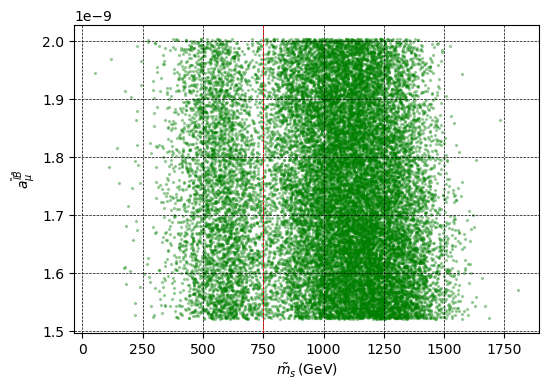

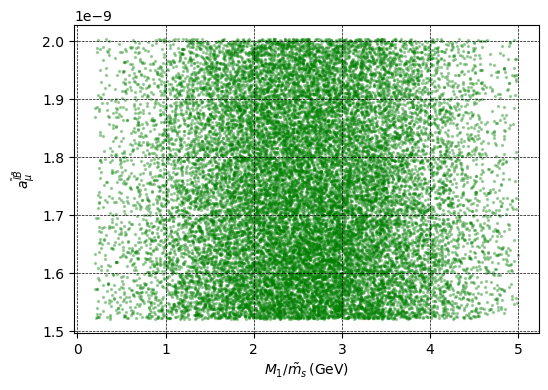

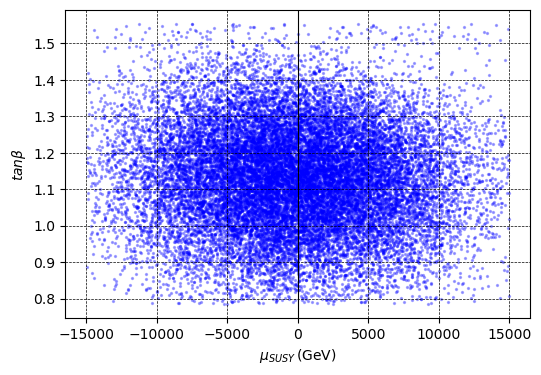

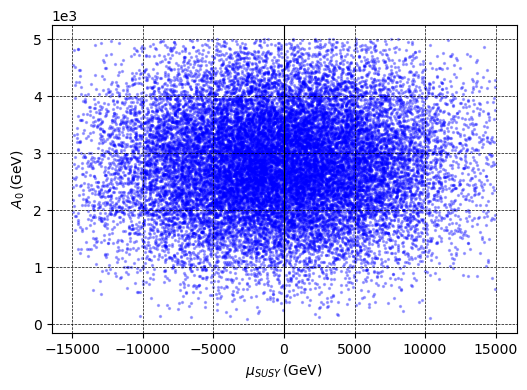

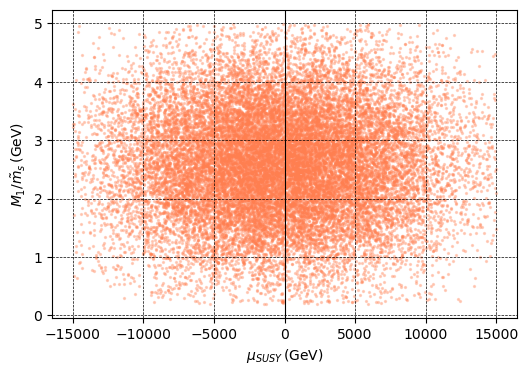

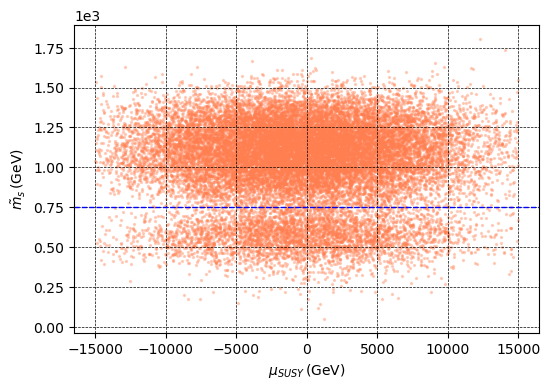

In [81]:
# Grahpics of parameters satisfying condition
#### FOR a_mu vs m_s
plt.figure(figsize=(6, 4))
plt.scatter(X[:,2], y, s=2, alpha=0.3, color='green', label="Puntos") 
plt.axvline(750, color="red", linewidth=0.6, linestyle='--')
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.xlabel(r"$\tilde{m}_{s} \, (\mathrm{GeV})$")
plt.ylabel(r"$a_\mu^{\tilde{l}\tilde{B}}$")
#plt.legend()
plt.grid(True, color='black', linestyle='--', linewidth=0.5) #cuadrícula
plt.savefig('a_mu_vs_ms', dpi=300, bbox_inches='tight')
plt.show()

######## For a_mu vs M1/ms
plt.figure(figsize=(6, 4))
plt.scatter(X[:,3], y, s=2, alpha=0.3, color='green', label="Puntos") 
#plt.axhline(0, color="green", linewidth=1)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.xlabel(r"$M_{1}/\tilde{m}_{s}\, (\mathrm{GeV})$")
plt.ylabel(r"$a_\mu^{\tilde{l}\tilde{B}}$")
#plt.legend()
plt.grid(True, color='black', linestyle='--', linewidth=0.5) #cuadrícula
plt.savefig('a_mu_vs_M1ms', dpi=300, bbox_inches='tight')
plt.show()

################ For tanbeta vs mu_SUSY
plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,4], s=2, alpha=0.3, color='blue', label="Puntos") 
plt.axvline(0, color="black", linewidth=0.8)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.xlabel(r"$\mu_{SUSY}\, (\mathrm{GeV})$")
plt.ylabel(r"$tan \beta$")
#plt.legend()
plt.grid(True, color='black', linestyle='--', linewidth=0.5) #cuadrícula
plt.savefig('tanbeta_vs_mu', dpi=300, bbox_inches='tight')
plt.show()

############### For A_0 vs mu_SUSY
plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,1], s=2, alpha=0.3, color='blue', label="Puntos") 
plt.axvline(0, color="black", linewidth=0.8)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.xlabel(r"$\mu_{SUSY}\, (\mathrm{GeV})$")
plt.ylabel(r"$A_{0}\, (\mathrm{GeV})$")
#plt.legend()
plt.grid(True, color='black', linestyle='--', linewidth=0.5) #cuadrícula
plt.savefig('A0_vs_mu', dpi=300, bbox_inches='tight')
plt.show()


############### For M1ms vs mu_SUSY
plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,3], s=2, alpha=0.3, color='coral', label="Puntos") 
plt.axvline(0, color="black", linewidth=0.8)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.xlabel(r"$\mu_{SUSY}\, (\mathrm{GeV})$")
plt.ylabel(r"$M_{1}/\tilde{m}_{s}\, (\mathrm{GeV})$")
#plt.legend()
plt.grid(True, color='black', linestyle='--', linewidth=0.5) #cuadrícula
plt.savefig('M1ms_vs_mu', dpi=300, bbox_inches='tight')
plt.show()

############### For ms vs mu_SUSY
plt.figure(figsize=(6, 4))
plt.scatter(X[:,0], X[:,2], s=2, alpha=0.3, color='coral', label="Puntos") 
plt.axhline(750, color="blue", linewidth=1, linestyle='--')
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
plt.xlabel(r"$\mu_{SUSY}\, (\mathrm{GeV})$")
plt.ylabel(r"$\tilde{m}_{s}\, (\mathrm{GeV})$")
#plt.legend()
plt.grid(True, color='black', linestyle='--', linewidth=0.5) #cuadrícula
plt.savefig('ms_vs_mu', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# Verify original data
print("Original output data (y):")
print(y)
#let's split into training and test data (X are filtered_params & y our a_muvalid)
# We need to scale the y values (a_muvalid) because they are on the order of 1e-9, which makes training the NN harder.
# Scale the y values
# Scale X and y using different scalers
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten() # reshape converts a 1D array into a 2D array, and .flatten converts a 2D matrix back to a 1D array as it originally was.


# Check scaled y values
print("\nOutput scaled (y) values:")
print(y_scaled)

# Same check for X
print("\nOutput scaled (X) values:")
print(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42) # random_state ensures the same data split every time the code runs; otherwise, you'd get a different split on each run.

Original output data (y):
[1.60990604e-09 1.95364127e-09 1.96710525e-09 ... 1.63290230e-09
 1.77679338e-09 1.56631193e-09]

Output scaled (y) values:
[0.18312274 0.89480878 0.92268525 ... 0.23073532 0.52865437 0.0928634 ]

Output scaled (X) values:
[[-0.93490074 -0.50230269  0.69649863  1.06655743 -1.11131727]
 [ 0.68992814 -0.56295461 -0.16181677  0.31098151  0.28067098]
 [-0.24678376  0.19033741  0.03788481 -0.11612127  0.65226241]
 ...
 [-0.46907777 -0.08277158 -1.18700639 -0.44716985 -2.23773809]
 [-1.66631848 -0.40125117 -1.53686577  0.36534081 -1.01000851]
 [ 0.41087844  0.82327446 -0.99708266  0.72244313 -1.61875532]]


In [58]:
start = perf_counter() 
model = Sequential([
    Input(shape=(5,)), #create the input layer explicity with 5 features 
    Dense(128, activation='relu', input_shape=(5,)), # 128 neurons, and input_dim=5 because there are 5 features per sample — (first layer, together with the above).
    # Dropout(0.5),  # dropout helps prevent overfitting.
    Dense(128, activation='relu'), 
    Dropout(0.2),  
    #Dropout(0.2),
    Dense(128, activation='relu'), # Second layer
    Dropout(0.2), # Turn off  50% or 20% of units in each iteration during training 
    # Dense(64, activation='relu'), # capa oculta con 64 neuronas #Aquí estamos probando con cuantas capas se ajusta mejor 
    # Dropout(0.5), # Apaga el 50% de las neuronas en cada iteración durante el entrenamiento
    Dense(1, activation='linear') # Output layer with one unit
])


# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error') # We tested learning rates of 0.1, 1e-1, 1e-2, 1e-3, 1e-4, and 1e-5, and the most suitable was --> 1e-3 <--
from tensorflow.keras.callbacks import EarlyStopping 

early_stop= EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train el modelo
#model.fit(X_train, y_train, epochs=80, batch_size=10, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])# We tested batch sizes of 8, 16, 32, and 64; 32 worked best.
# We also tried between 10 and 90 epochs with this configuration.
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Predict with model
y_pred_scaled = model.predict(X_test)

# Inverse-transform (unscale) the predictions to return to the original ranges
y_pred = scaler_y.inverse_transform(y_pred_scaled)

#Unscale real values in order to compare both
y_test_descaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()  
print("Unscaled predictions:")
print(y_pred)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_descaled, y_pred)
mae = mean_absolute_error(y_test_descaled, y_pred)
r2 = r2_score(y_test_descaled, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

end= perf_counter()
print(f'Time(s): {end-start}')
# Imprimir las predicciones y los valores reales
print("\nPredictions vs Real values:")
for i in range(len(y_test_descaled)):
    print(f'Predicción: {y_pred[i][0]:.10f}, Valor Real: {y_test_descaled[i]:.10f}')
    

D:\Santi\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0995 - val_loss: 0.0273
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0291 - val_loss: 0.0227
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0238 - val_loss: 0.0202
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0221 - val_loss: 0.0192
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0195 - val_loss: 0.0206
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 8/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0197 - val_loss: 0.0187
Epoch 9/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0187 - val_loss: 0.0178
Epoch 10/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0199 - val_loss: 0.0171
Epoch 11/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 12/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

# TESTING a_mu as a library (Gamma and weibull remain)

In [59]:
import importlib, a_mu_susy_gamma 
a_mu_susy = importlib.reload(a_mu_susy_gamma) #this is for obtain new values on each call you do 
X = a_mu_susy_gamma.X
y= a_mu_susy_gamma.y
print(f'Filtered parameters shape and values:{X.shape}, {X}')
print(f'$a_muvalid$ related to this parameters shape and values:{y.shape}, {y}')


Number of times the loop ran to change the value: 1
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 2
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 2

Number of times the loop ran to change the value: 2
Duración(s): 249.00345370010473

Number of times the loop ran to change the value: 2
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 1
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still pr

In [60]:
import importlib, a_mu_susy_weibull 
a_mu_susy = importlib.reload(a_mu_susy_weibull) #this is for obtain new values on each call you do 
X = a_mu_susy_weibull.X
y= a_mu_susy_weibull.y
print(f'Filtered parameters shape and values:{X.shape}, {X}')
print(f'$a_muvalid$ related to this parameters shape and values:{y.shape}, {y}')


Number of times the loop ran to change the value: 1
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 2
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 2

Number of times the loop ran to change the value: 1

Number of times the loop ran to change the value: 2

Number of times the loop ran to change the value: 3
Duración(s): 170.4950745999813

Number of times the loop ran to change the value: 1
x1 values that produce a negative result [0 0 0 ... 0 0 0]
x2 values — with the adjusted m_s that still produce a negative result [0 0 0 ... 0 0 0]

Number of times the loop ran to change the value: 2
x3 values that produce negative result [0 0 0 ... 0 0 0]
x4 values with the adjsusted m_s that still pro